In [1]:
%matplotlib inline
from memory_profiler import memory_usage
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [2]:
import keras
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, GaussianNoise
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import librosa
import librosa.display
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import random
import warnings
warnings.filterwarnings('ignore')

#object serialization
import _pickle as cPickle  #python 3 change
import os  

%matplotlib inline

Using TensorFlow backend.


In [3]:
#enable memory profiler for memory management usage %%memit 
%load_ext memory_profiler

#enable garbage collection control
import gc
gc.enable()

In [4]:
#progress tracker
from tqdm import tqdm, tqdm_notebook

In [5]:
# when set to TRUE, training data get loaded from a saved serialized data object file 
# All audio files data get saved to a serialized object file to save reloading time on training runs 

# Note: 
# On first time run, if serialized file doesn't exist, this flag will get overrident 

SKIP_AUDIO_RELOAD = False

In [6]:
#location of the sound files
INPUT_PATH='/Users/Bruker/prosjektH19'


TRAIN_INPUT=INPUT_PATH+'/train'
TRAIN_AUDIO_DIR=TRAIN_INPUT+'/Train'

TEST_INPUT=INPUT_PATH+'/test'
TEST_AUDIO_DIR=TEST_INPUT+'/Test'

In [7]:
def load_input_data(pd, filepath):
    # Read Data
    data = pd.read_csv(filepath)
    return data

In [10]:
# training file
TRAIN_FILE=TRAIN_INPUT+'/train.csv'
train_input=load_input_data(pd,TRAIN_FILE)

# test file
TEST_FILE=TEST_INPUT+'/test.csv'
test_input=load_input_data(pd,TEST_FILE)

In [11]:
#labels
valid_train_label = train_input[['Class']]
#x=data['label'].unique()
valid_train_label.count()

#unique classes
x = train_input.groupby('Class')['Class'].count()
x

Class
Chaffinch      99
Jack Snipe    100
Wind          100
Name: Class, dtype: int64

In [12]:
# train data size
valid_train_data = train_input[['file_ID', 'Class']] 
valid_train_data.count()

file_ID    299
Class      299
dtype: int64

In [13]:
# test data size
valid_test_data = test_input[['file_ID']] 
valid_test_data.count()

file_ID    18
dtype: int64

In [15]:
#training audio files
valid_train_data['path'] = TRAIN_AUDIO_DIR+'/' + train_input['file_ID'].astype('str')+".wav"
print ("sample",valid_train_data.path[1])
valid_train_data.head(5)

sample /Users/Bruker/prosjektH19/train/Train/filter_sample3.wav


,file_ID,Class,path
0,filter_sample2,Jack Snipe,/Users/Bruker/prosjektH19/train/Train/filter_s...
1,filter_sample3,Jack Snipe,/Users/Bruker/prosjektH19/train/Train/filter_s...
2,filter_sample4,Jack Snipe,/Users/Bruker/prosjektH19/train/Train/filter_s...
3,filter_sample43,Jack Snipe,/Users/Bruker/prosjektH19/train/Train/filter_s...
4,filter_sample44,Jack Snipe,/Users/Bruker/prosjektH19/train/Train/filter_s...


In [16]:
#test audio files
valid_test_data['path'] = TEST_AUDIO_DIR+'/' + test_input['file_ID'].astype('str') +".wav"
print ("sample",valid_test_data.path[1])

valid_test_data.head(5)

sample /Users/Bruker/prosjektH19/test/Test/Jacksnipe_9-4-2.wav


,file_ID,path
0,Jacksnipe_9-3-2,/Users/Bruker/prosjektH19/test/Test/Jacksnipe_...
1,Jacksnipe_9-4-2,/Users/Bruker/prosjektH19/test/Test/Jacksnipe_...
2,Jacksnipe_9-8,/Users/Bruker/prosjektH19/test/Test/Jacksnipe_...
3,Jacksnipe_9-6-2,/Users/Bruker/prosjektH19/test/Test/Jacksnipe_...
4,Jacksnipe_9-13,/Users/Bruker/prosjektH19/test/Test/Jacksnipe_...


In [17]:
# set duration on audio loading to make audio content to ensure each training data have same size
audio_play_duration=3

def load_audio_file(file_path, duration=3, sr=22050):
    #load 3 seconds audio file, sampling rate sr=22050
    # To preserve the native sampling rate of the file, use sr=None
    input_length=sr*duration
    # Load an audio file as a floating point time series.
    # y : np.ndarray [shape=(n,) or (2, n)] - audio time series
    # sr : number > 0 [scalar] - sampling rate of y
    y, sr = librosa.load(file_path,sr=sr, duration=duration)
    dur = librosa.get_duration(y=y)
    #pad output if audio file less than duration
    # Use edge-padding instead of zeros
    if (round(dur) < duration):
        offset = len(y) - round(input_length)
        print ("fixing audio length :", file_path)
        print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
        y = librosa.util.fix_length(y, round(input_length))      
        y = librosa.util.normalize(y)
    # using a pre-computed power spectrogram
    # Short-time Fourier transform (STFT)
    #D = np.abs(librosa.stft(y))**2
    #ps = librosa.feature.melspectrogram(S=D)    # ENDRE SR FOR Å SE OM DET KAN HJELPE
    ps = librosa.feature.melspectrogram(y=y, sr=2000, )
    return ps

In [18]:
%%time
#%%memit 
# Dataset
train_audio_data = [] 
train_object_file='saved_train_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(train_object_file):
    SKIP_AUDIO_RELOAD = False

#load training data
if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TRAINING data from audio files")
else:
    print ("loading train audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_train_data.itertuples()):
            ps = load_audio_file(file_path=row.path, duration=3.0)
            if ps.shape != (128, 130): continue
            train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))
# have 300 samples, took 10 seconds to finish

loading train audio data, may take more than 15 minutes. please wait!


299it [00:15, 19.07it/s]


Number of train samples:  298
Wall time: 15.7 s


In [19]:
# load saved data
test_audio_data = []
test_object_file='saved_test_audio_data.p'
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(test_object_file, 'rb'))
    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(test_object_file, 'wb')) 
    print ("save loaded test data :", len(test_audio_data))

save loaded test data : 0


In [20]:
#prepare for training
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from numpy import argmax

# get a set of unique text labels
list_labels = sorted(list(set(valid_train_data.Class.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(valid_train_data.path.values, valid_train_data.file_ID.values)}
#print("file_to_label:", file_to_label)
# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
print ("test label to int ",label_to_int["Wind"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}
print ("int to label: ",int_to_label)



unique text labels count:  3
labels:  ['Chaffinch', 'Jack Snipe', 'Wind']
encoded labelint values [0 1 2]
test label to int  2
int to label:  {0: 'Chaffinch', 1: 'Jack Snipe', 2: 'Wind'}


In [21]:
#full dataset
dataset = train_audio_data
random.shuffle(dataset)

In [22]:
RATIO=0.7
train_cutoff= round(len(dataset) * RATIO)
train = dataset[:train_cutoff]
test = dataset[train_cutoff:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (128, 130, 1) ) for x in X_train])
X_test = np.array([x.reshape( (128, 130, 1) ) for x in X_test])

print ("train ",X_train.shape, len(y_train))
print ("test ", X_test.shape, len(y_test))

train  (209, 128, 130, 1) 209
test  (89, 128, 130, 1) 89


In [23]:
# Apply sck-learn label text encoding to integer
label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train)
y_test_integer_encoded = label_encoder.fit_transform(y_test)

print('y_test:', y_test_integer_encoded)

y_test: [1 1 0 2 2 2 0 0 2 2 1 0 2 1 0 1 0 2 2 1 0 1 0 2 0 2 2 0 0 1 2 0 1 2 1 1 1
 2 2 0 1 1 2 0 2 1 2 2 2 0 1 2 1 0 2 1 2 0 2 2 2 1 2 2 2 1 0 0 1 1 0 1 1 0
 2 2 2 0 0 1 0 1 0 1 2 1 1 1 2]


In [24]:
# Apply Keras One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train_integer_encoded, len(list_labels)))
y_test = np.array(keras.utils.to_categorical(y_test_integer_encoded, len(list_labels)))

In [25]:
#split up test into test and validation, to test the learned model on unseen data. relation 70/30. 
# Random state to ensure that the order in the test/validation set does not rocade for each run
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state = 42)

print ("test ",X_test.shape, len(y_test))
print ("valid ", X_val.shape, len(y_val))


test  (62, 128, 130, 1) 62
valid  (27, 128, 130, 1) 27


In [26]:
# Apply weight to balance the classes
Class_Weights = class_weight.compute_class_weight('balanced', np.unique(y_train_integer_encoded), y_train_integer_encoded)

In [27]:
# build convolution model
# input shape = (128, 130, 1)
model = Sequential()
input_shape= X_train.shape[1:] 

model.add(Conv2D(16, (3, 3), strides=(1, 1), input_shape=input_shape))
model.add(MaxPooling2D(2))
model.add(Activation('relu'))

model.add(Conv2D(24, (3, 3), padding="valid"))
model.add(MaxPooling2D(pool_size = 2))
model.add(Activation('relu'))

model.add(Conv2D(36, (3, 3), padding="valid"))
model.add(MaxPooling2D(pool_size=2))
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dropout(rate=0.5))

model.add(Dense(36))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

model.add(Dense(len(list_labels)))
model.add(Activation('softmax'))

model.summary()




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 128, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 64, 16)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 63, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 62, 24)        3480      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 31, 24)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 30, 31, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 29, 36)       

In [28]:
%%time

MAX_EPOCHS= 5
MAX_BATCH_SIZE= 23           
MAX_PATIENT= 2  

# saved model checkpoint file
best_model_file="./best_CNN_model_trained_AC.hdf5"

# callbacks
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

#compile
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

#train
print('training started.... please wait!')

history = model.fit(x=X_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE, 
                    verbose=0,
                    validation_data= (X_val, y_val), 
                    callbacks=callback)
print('training finished')
# 
# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])


training started.... please wait!

Epoch 00001: loss improved from inf to 0.91877, saving model to ./best_CNN_model_trained_AC.hdf5

Epoch 00002: loss improved from 0.91877 to 0.60546, saving model to ./best_CNN_model_trained_AC.hdf5

Epoch 00003: loss improved from 0.60546 to 0.35000, saving model to ./best_CNN_model_trained_AC.hdf5

Epoch 00004: loss improved from 0.35000 to 0.26177, saving model to ./best_CNN_model_trained_AC.hdf5

Epoch 00005: loss improved from 0.26177 to 0.16556, saving model to ./best_CNN_model_trained_AC.hdf5
training finished
Evaluate model with test data
62/62 [==============================] - ETA:  - 0s 3ms/step
test loss: 0.255260580970395
test accuracy: 0.9354838728904724
Wall time: 13.5 s


<Figure size 1584x720 with 0 Axes>

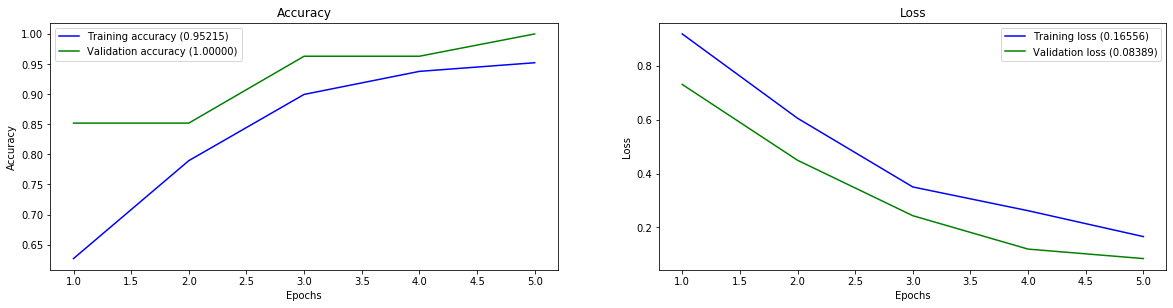

Wall time: 4.66 s


In [29]:
%%time
#%%memit

import matplotlib.pyplot as plt
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [30]:
#Evaludate model use Keras reported accuracy:
score = model.evaluate(X_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(X_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  97 %
model test data score        :  94 %
model validation data score  :  100 %


In [629]:
# f1 score by using the classification report from the sklearn libary

from sklearn.metrics import classification_report
import numpy as np


y_true = np.argmax(y_test, axis = 1)
X_valid = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
labels = [0,1,2]
target_names = list_labels 

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(62,) (62,)
              precision    recall  f1-score   support

   Chaffinch       1.00      1.00      1.00        19
  Jack Snipe       0.88      1.00      0.93        21
        Wind       1.00      0.86      0.93        22

    accuracy                           0.95        62
   macro avg       0.96      0.95      0.95        62
weighted avg       0.96      0.95      0.95        62



In [31]:
# Prediction test
print ("Prediction with [train] data")
y_pred = model.predict_classes(X_train)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_train[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  --> match    :", len(matched))
print ("  --> miss     :", len(missed))
print ("  --> accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show the samples that miss-matched
print ("---samples---")
for i in range(209):
    if int_to_label[y_pred[i]] != int_to_label[argmax(y_train[i])]:
        print('predict', int_to_label[y_pred[i]])
        print('original', int_to_label[argmax(y_train[i])])
        print ("")

Prediction with [train] data
  --> match    : 203
  --> miss     : 6
  --> accuracy : 97.04 %

---samples---
predict Jack Snipe
original Wind

predict Jack Snipe
original Chaffinch

predict Jack Snipe
original Chaffinch

predict Jack Snipe
original Wind

predict Jack Snipe
original Wind

predict Jack Snipe
original Wind



In [631]:
# prediction class 
print ("Prediction with [test] data")
y_pred = model.predict_classes(X_test)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_test[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  --> match    :", len(matched))
print ("  --> miss     :", len(missed))
print ("  --> accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(62):
    print(i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_test[i])])
    print ("")
    

Prediction with [test] data
  --> match    : 59
  --> miss     : 3
  --> accuracy : 94.92 %

---samples---
0 predict = Jack Snipe
0 original= Jack Snipe

1 predict = Chaffinch
1 original= Chaffinch

2 predict = Jack Snipe
2 original= Jack Snipe

3 predict = Chaffinch
3 original= Chaffinch

4 predict = Wind
4 original= Wind

5 predict = Jack Snipe
5 original= Jack Snipe

6 predict = Chaffinch
6 original= Chaffinch

7 predict = Chaffinch
7 original= Chaffinch

8 predict = Wind
8 original= Wind

9 predict = Jack Snipe
9 original= Jack Snipe

10 predict = Wind
10 original= Wind

11 predict = Wind
11 original= Wind

12 predict = Jack Snipe
12 original= Jack Snipe

13 predict = Chaffinch
13 original= Chaffinch

14 predict = Jack Snipe
14 original= Jack Snipe

15 predict = Chaffinch
15 original= Chaffinch

16 predict = Wind
16 original= Wind

17 predict = Chaffinch
17 original= Chaffinch

18 predict = Jack Snipe
18 original= Jack Snipe

19 predict = Chaffinch
19 original= Chaffinch

20 predic

In [632]:
# prediction class 
print ("Prediction with [validation] data")
y_pred = model.predict_classes(X_val)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_val[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")

# show sample results
print ("---samples---")
for i in range(14):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_val[i])])
    print ("")

Prediction with [validation] data
  |__match    : 26
  |__miss     : 1
  |__accuracy : 96.15 %

---samples---
0 predict = Wind
0 original= Wind

1 predict = Jack Snipe
1 original= Jack Snipe

2 predict = Wind
2 original= Wind

3 predict = Wind
3 original= Wind

4 predict = Jack Snipe
4 original= Jack Snipe

5 predict = Jack Snipe
5 original= Jack Snipe

6 predict = Chaffinch
6 original= Chaffinch

7 predict = Jack Snipe
7 original= Jack Snipe

8 predict = Wind
8 original= Wind

9 predict = Wind
9 original= Wind

10 predict = Chaffinch
10 original= Chaffinch

11 predict = Wind
11 original= Wind

12 predict = Chaffinch
12 original= Chaffinch

13 predict = Jack Snipe
13 original= Jack Snipe

